# Prediction of Molecular Pathways and Key Mutations

<a href="https://colab.research.google.com/github/TIA-Lab/tiatoolbox/blob/master/examples/07_example_mutationprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://kaggle.com/kernels/welcome?src=https://github.com/TIA-Lab/tiatoolbox/blob/master/examples/06_example_mutationprediction.ipynb" target="_blank"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Kaggle"/></a>

_In order to run this notebook on a Kaggle platform, 1) click on the blue Kaggle badge saying Open in Kaggle 2) click on Settings on the right of the Kaggle screen, 3) log in to your Kaggle account, 4) tick "Internet" checkbox under Settings, to enable necessary downloads._

## About this notebook
This jupyter notebook can be run on any computer with a standard browser and no prior installation of any programming language is required. It can run remotely over the Internet, free of charge, thanks to Google Colaboratory or Kaggle. To connect with Colab or Kaggle, click on one of the two blue checkboxes above. Check that "colab" or "kaggle", as appropriate, appears in the address bar. You can right-click on "Open in Colab" and select "Open in new tab" if the left click does not work for you. Familiarize yourself with the drop-down menus near the top of the window. You can edit the notebook during the session, for example substituting your own image files for the image files used in this demo. Experiment by changing the parameters of functions. It is not possible for an ordinary user to permanently change this version of the notebook on Github, Colab or Kaggle, so you cannot inadvertently mess it up. Use the notebook's File Menu if you wish to save your own (changed) notebook.

To run the notebook on any platform, except for Colab or Kaggle, set up your Python environment, as explained in the 
[README](https://github.com/TIA-Lab/tiatoolbox/blob/master/README.md#install-python-package) file.

## About this demo
Prediction of molecular pathways and key mutations directly from Haematoxylin and Eosin stained histology images can help bypass additional genetic (e.g., polymerase chain reaction or PCR) or immunohistochemistry (IHC) testing, which can therefore save both money and time.  

In this example notebook, we show how you can use pretrained models to do reproduce the results obtained by Bilal et al. Here, the pipeline utilises a two-stage approach:

- Patch-level tumour segmentation
- Patch-level WSI prediction

In step 1, we use a pretrained tumour segmentation model to identify potentially diagnositc areas. In step 2, we make a task-epcific prediction for each tumour patch. In TIATooolbox, we include models that are capable of predicting:

- Microsatellite instability
- Hypermutation density
- Chromosomal instability
- CpG island methylator phenotype (CIMP)-high prediction
- BRAF mutation
- TP53 mutation


### Setting up the environment
The cell below removes some redundant directories of they exist—a previous run may have created them. This cell can be skipped if you are running this notebook for the first time.

In [1]:
![ -d tmp ] && ( echo "deleting tmp directory"; rm -rf tmp )
![ -d sample_tile_results ] && !( echo "deleting 'sample_tile_results' directory"; rm -r sample_tile_results)
![ -d sample_wsi_results ] && ( echo "deleting 'sample_wsi_results' directory"; rm -r sample_wsi_results)
![ -d tissue_mask_results ] && ( echo "deleting 'tissue_mask_results' directory"; rm -r tissue_mask_results)
import warnings
warnings.filterwarnings('ignore')

You can skip the following cell if 1) you are not using the Colab or Kaggle plaforms or 2) you are using Colab or Kaggle and this is not your first run of the notebook in the current session. If you nevertheless run the cell, you may get an error message, but no harm will be done. On Colab or Kaggle the cell installs `tiatoolbox`, and other prerequisite software. Harmless error messages should be ignored. Outside Colab or Kaggle, the notebook expects `tiatoolbox` to already be installed. (See the instructions in [README](https://github.com/TIA-Lab/tiatoolbox/blob/master/README.md#install-python-package).)

In [2]:
!apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools | tail --line 1
!pip install tiatoolbox | tail --line 1
ON_GPU = False
print('Installation is done.')

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
Installation is done.


**[optional]**: if you are running this example notebook on your system and it is equipped with a Cuda enabled GPU, you can run the following cell to install Cuda enabled version of the torch package to utilize GPU computation and speed up the Tiatoolbox models.

In [3]:
!pip install torch==1.9.1+cu102 torchvision==0.10.1+cu102 -f https://download.pytorch.org/whl/cu102/torch_stable.html --user
ON_GPU = True

Looking in links: https://download.pytorch.org/whl/cu102/torch_stable.html


### Importing related libraries

We import some standard Python modules, and also the Python module `wsireader` (see [details](https://github.com/TIA-Lab/tiatoolbox/blob/master/tiatoolbox/wsicore/wsireader.py)) written by the TIA Centre team.

In [5]:
from tiatoolbox.models.controller.patch_predictor import IOPatchPredictorConfig, CNNPatchPredictor
from tiatoolbox.models.architecture.vanilla import CNNModel
from tiatoolbox.utils.misc import imread
from tiatoolbox.wsicore.wsireader import get_wsireader

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, glob

mpl.rcParams['figure.dpi'] = 300 # for high resolution figure in notebook

### Downloading the required files
We download, over the internet, image files used for the purpose of this notebook. In particular, we download a histology tile and a whole slide image of cancerous breast tissue samples to show how semantic segmentation models work. Also, pretrained weights of a Pytorch model and a small WSI are downloaded to illustrate how you can incorporate your own models in the existing Tiatoolbox segmentation tool.
> In Colab, if you click the files icon (see below) in the vertical toolbar on the left hand side then you can see all the files which the code in this notebook can access. The data will appear here when it is downloaded.
>
> 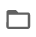

In [6]:
import requests

wsi_file_name = "sample_wsi.svs"
print('Download has started. Please wait...')

# Downloading sample whole-slide image
r = requests.get("https://tiatoolbox.dcs.warwick.ac.uk/sample_wsis/TCGA-3L-AA1B-01Z-00-DX1.8923A151-A690-40B7-9E5A-FCBEDFC2394F.svs")
with open(wsi_file_name, "wb") as f:
    f.write(r.content)

print('Download is complete.')

Download has started. Please wait...
Download is complete.


## Tumour segmentation using TIAToolbox pretrained models
In this section, we will display patch-level tumour segmentation results using a pretrained model used in the original paper by Bilal et al. In particular, this model is a ResNet model with 18 layers (resnet18). Each prediction is made for each input patch within the tissue region that denotes the probability of being tumour. 

> More information on the model and the dataset used for training can be found [here](https://www.thelancet.com/journals/landig/article/PIIS2589-7500(21)00180-1/fulltext) (_Bilal et al., "Development and validation of a weakly supervised deep learning framework to predict the status of molecular pathways and key mutations in colorectal cancer from routine histology images: a retrospective study"_)

In line with the patch prediction model provided in `tiatoolbox`, the tumour segmentation model can be applied to input patches, large images tiles or whole-slide images. In order to replicate the original pipeline, we choose to process a sample whole-slide image.

In [9]:
tumour_predictor = CNNPatchPredictor(pretrained_model='resnet18-idars-tumour', batch_size=64)

tumour_output = tumour_predictor.predict(
    imgs=[wsi_file_name], 
    mode='wsi',
    stride_size=[512,512], 
    resolution=0.5,
    units='mpp',
    return_probabilities=True, 
    on_gpu=True) 

ValueError: Pretrained model `resnet18-idars-tumour` does not exist.

In [ ]:
print(tumour_output[0]['units'])

As can be seen above, with just a few lines of code we are capable of performing tumour segmentation on whole-slide images. Here, the patch size used is 512x512, which is selected as the default size in line with that used for training the pretrained model.

You may adjust the `stride_size` to control how much overlap is used between neighbouring predicted patches. Note, if using a small `stride_size` (large overlap), then the model will take longer to process the input.

Below, we show the output probability map, along with the thresholded output that will be used in the second step.

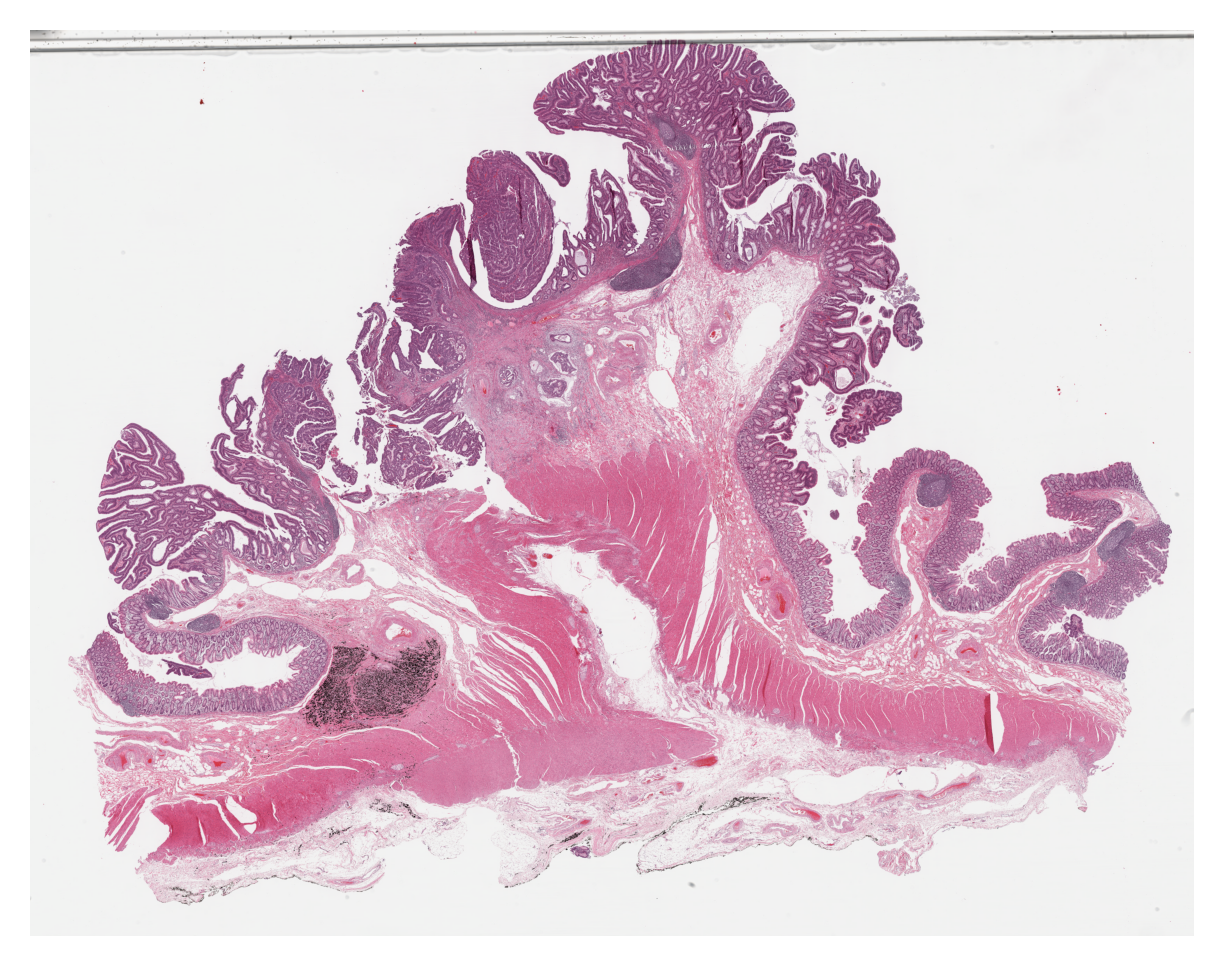

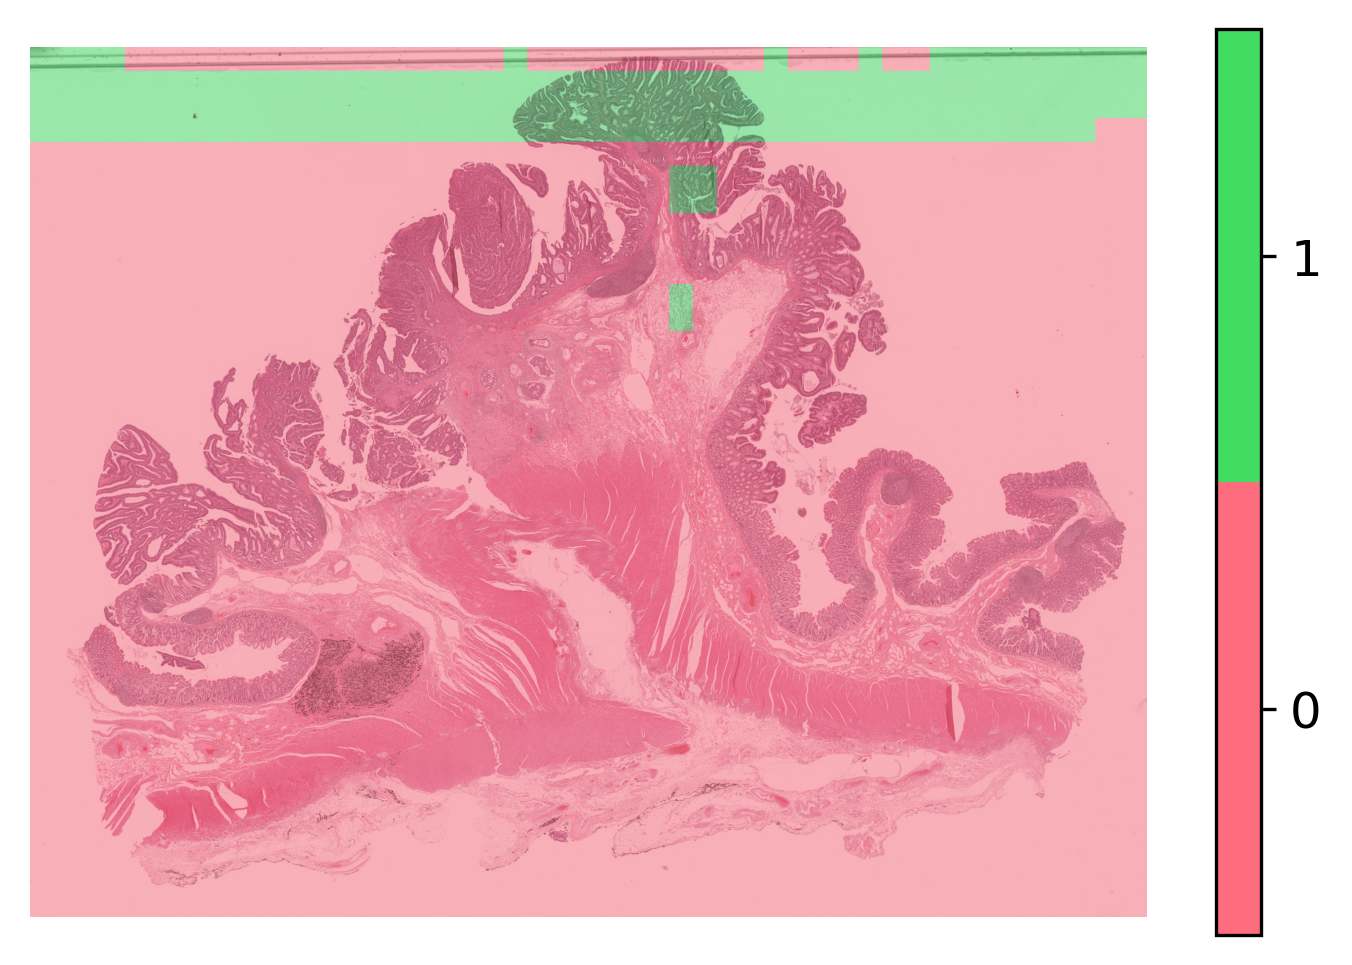

In [7]:
from tiatoolbox.utils.visualization import overlay_patch_prediction

# visualization of whole-slide image patch-level prediction
overview_resolution = 1.25 # the resolution in which we desire to merge and visualize the patch predictions
overview_unit = "power" # the unit of the `resolution` parameter. Can be "power", "level", "mpp", or "baseline"
wsi = get_wsireader(wsi_file_name)
wsi_overview = wsi.slide_thumbnail(resolution=overview_resolution, units=overview_unit)
plt.figure(), plt.imshow(wsi_overview); plt.axis('off')

pred_map = tumour_predictor.merge_predictions(wsi_file_name, tumour_output[0], resolution=overview_resolution, units=overview_unit)
overlay = overlay_patch_prediction(wsi_overview, pred_map, alpha=0.5)
plt.show()

## WSI prediction using TIAToolbox pretrained models
Here, we show how one can use a second CNN that takes as input the result obtained from part 1 and gives a prediction for each tumour patch in the input WSI. When conducting the experiments reported in the original paper, 4 fold cross validation was used. Therefore, we supply the weights of each fold for each WSI prediction task. In line with the original paper, all models in the second step were ResNet34.


In [ ]:
print('prediction method output is: {}'.format(output))
tile_prediction_raw = np.load(output[0][1]+'.raw.0.npy') # Loading the first prediction [0] based on the output address [1]
print('Raw prediction dimensions: {}'.format(tile_prediction_raw.shape))

# Simple processing of the raw prediction to generate semantic segmentation task
tile_prediction = np.argmax(tile_prediction_raw, axis=-1) # select the class with highest probability
print('Processed prediction dimensions: {}'.format(tile_prediction.shape))

# showing the predicted semantic segmentation
tile = imread(img_file_name)
print('Input image dimensions: {}'.format(tile.shape))

fig = plt.figure()
label_names_dict = {0: 'Tumour', 1: 'Stroma', 2: 'Inflamatory', 3: 'Necrosis', 4: 'Others'}
for i in range(5):
  ax = plt.subplot(1,5,i+1)
  plt.imshow(tile_prediction_raw[:, :, i]), plt.xlabel(label_names_dict[i]), ax.axes.xaxis.set_ticks([]), ax.axes.yaxis.set_ticks([])
fig.suptitle('Row prediction maps for different classes', y=0.65)

# showing processed results
fig2 = plt.figure()
ax1 = plt.subplot(1,2,1), plt.imshow(tile), plt.axis('off')
ax2 = plt.subplot(1,2,2), plt.imshow(tile_prediction), plt.axis('off')
fig2.suptitle('Processed prediction map', y=0.82)


As printed above, the raw prediction array has 5 channels (size 4000x4000x**5**) which indicate the 5 categories that our segmentation model can distinguish. These prediction channels are illustrated in the first row, one-by-one, where each prediction map stands for a specific tissue region class. However, the idea is to have a single prediction map that contains specific values for each class. Therefore, we use a very simple post-processing technique to acquire the semantic segmentation map:
> `tile_prediction = np.argmax(tile_prediction_raw, axis=-1)`

that finds, for each pixel, the class index that has the highest estimated probability. In the processed prediction map dark blue, light blue, dark green, light green, and yellow colours stand for tumour, stroma, inflamatory, necrosis, and other region types, respectively.

### Inference on WSIs
The next step is to use the Tiatoolbox's embedded model for region segmentation in a whole slide image. The process is quite similar to what we have done for tiles. Here we just introduce a some important paramters that should be considered when configuring the segmentor for WSI inference.

In [ ]:
bcc_segmentor = SemanticSegmentor(
    pretrained_model="fcn_resnet50_unet-bcss",
    num_loader_workers=4, batch_size=4,
    auto_generate_mask=False
)

bcc_wsi_ioconfig = IOSegmentorConfig(
    input_resolutions=[
            {'units': 'mpp', 'resolution': 0.25}
        ],
        output_resolutions=[
            {'units': 'mpp', 'resolution': 0.25}
        ],
        patch_input_shape=[1024, 1024],
        patch_output_shape=[512, 512],
        stride_shape=[512, 512],
        save_resolution={'units': 'mpp', 'resolution': 2}
)

Here we re-defined the `bcc_segmentor` just to show the use of `auto_generate_mask` parameter. By setting this parameter to `True`, we are telling the Tiatoolbox to automatically extract the tissue masks of the input WSIs if they are not provided in the `predict` function parameters.
In this example, we leave `auto_generate_mask=False` because we are using a WSI that only contains tissue region (there is no background region) and therefore there is no need for tissue mask extraction.

When doing inference on WSIs, it is important to set the data stream configurations (such as input resolution, output resolution, size of merged predictions, etc.) appropritely for each model and application. In Tiatoolbox, `IOSegmentorConfig` class is used to set these configurations as we have done in the above cell.
Parameters of `IOSegmentorConfig` have self-explanatory names, but let's have look at their definition:
- `input_resolutions`: a list specifying the resolution of each input head of model in the form of a dictionary. List elements must be in the same order as target `model.forward()`. Of course, if your model accepts only one input, you just need to put one dictionary specifying `'units'` and `'resolution'`. But it's good to know that Tiatoolbox supports a model with more than one input!
- `output_resolutions`: a list specifying the resolution of each output head from model in the form of a dictionary. List elements must be in the same order as target `model.infer_batch()`.
- `patch_input_shape`: Shape of the largest input in (height, width) format.
- `patch_output_shape`: Shape of the largest output in (height, width) format.
- `save_resolution`: specifies the resolution in which processed (merged) output will be saved. Commonly, we desire the resolution (size) of the output segmentation map to be smaller than the input map. For example, we don't need the tissue segmentation results to be as high-resolution as input WSI. Therefore, this parameter can be set based on the model, task, and desired output size.




In [ ]:
# WSI prediction
wsi_output = bcc_segmentor.predict(
        imgs=[wsi_file_name],
        masks=None,
        save_dir="sample_wsi_results/",
        mode="wsi",
        ioconfig=bcc_wsi_ioconfig,
        on_gpu=ON_GPU,
        crash_on_exception=True,
    )

Note the only differences made here are:
1. Adding `auto_generate_mask=False` to the `SemanticSegmentor`. If `True`, the toolbox automatically extracts tissue masks from WSIs if there is no `masks` input is provided to the `predict` function.
2. Setting `mode='wsi'` in the `predict` function indicates that we are predicting region segmentations for inputs in the form of WSIs.
3. `masks=None` in the `predict` function: `masks` argument similar to the `imgs` should be a list of paths to the desired image masks. Patches from `imgs` are only processed if they are within a masked area of their corresponding `masks`. If not provided (`masks=None`), then a tissue mask will be automatically generated for whole-slide images or the entire image is processed for image tiles.

The above cell might take a while to process, especially if you have set `ON_GPU=False`. The processing time depends on the size of the input WSI and the selected resolution. Here, we have not specified any values, which means that the `baseline` resolution of the WSI, which is 40x in this example, will be used.

In [ ]:
from matplotlib import cm
from tiatoolbox.utils.visualization import overlay_patch_prediction

print('prediction method output is: {}'.format(wsi_output))
wsi_prediction_raw = np.load(wsi_output[0][1]+'.raw.0.npy') # Loading the first prediction [0] based on the output address [1]
print('Raw prediction dimensions: {}'.format(wsi_prediction_raw.shape))

# [Post-processing]
# Simple processing of the raw prediction to generate semantic segmentation task
wsi_prediction = np.argmax(wsi_prediction_raw, axis=-1) # select the class with highest probability
print('Processed prediction dimensions: {}'.format(wsi_prediction.shape))

# [WSI overview extraction]
# Now reading the WSI to extract it's overview
wsi = get_wsireader(wsi_file_name)
print('WSI original dimensions: {}'.format(wsi.info.slide_dimensions))

# using the prediction save_resolution to create the wsi overview at the same resolution
overview_info = bcc_wsi_ioconfig.save_resolution

# extracting slide overview using `slide_thumbnail` method
wsi_overview = wsi.slide_thumbnail(resolution=overview_info['resolution'], units=overview_info['units'])
print('WSI overview dimensions: {}'.format(wsi_overview.shape))
plt.figure(), plt.imshow(wsi_overview); plt.axis('off')

# [Overlay map creation]
# creating label-color dictionary to be fed into `overlay_patch_prediction` function to help generating color legend
label_dict = {'Tumour': 0, 'Stroma': 1, 'Inflamatory': 2, 'Necrosis':3, 'Others':4}
label_color_dict = {}
colors = cm.get_cmap('Set1').colors
for class_name, label in label_dict.items():
    label_color_dict[label] = (class_name, 255*np.array(colors[label]))
# Creat overlay map using thhe `overlay_patch_prediction` helper function
overlay = overlay_patch_prediction(wsi_overview, wsi_prediction, alpha=0.5, label_info=label_color_dict)

As you can see above, we first post-process the prediction map, the same way as we did for tiles (taking `argmax` of the model output), to create the semantic segmentation map. Then, in order to visualise the segmentation prediction on the tissue image, we read the processed WSI and extract its overview. Please note that the overview is extracted at the same resolution as the saved prediction output (accessed through `bcc_wsi_ioconfig.save_resolution`). Finally, we used the `overlay_patch_prediction` helper function of the Tiatoolbox to overlay the prediction map on the overview image and depict it with a colour legend.

In summary, it is very easy to use pretrained models in the Tiatoolbox to do predefined tasks. In fact, you don't even need to set any parameters related to a model’s input/output when you decide to work with one of Tiatoolbox’s pretrained models (they will be set automatically, based on their optimal values). Here we explain how the parameters work, so we need to show them explicitly.. In other words, region segmentation in images can be done as easily as:
```
segmentor = SemanticSegmentor(pretrained_model="fcn_resnet50_unet-bcss" num_loader_workers=4, batch_size=4)
output = segmentor.predict([img_file_name], save_dir="sample_tile_results/", mode="tile")
```

Having said that, you may need to take care of a couple of other things if you want to use the same model with new weights, or even use a whole new model in the Tiatoolbox inference pipeline. But don't worry, these will be covered in the next section of this notebook.

## Semantic segmentation using user-trained (external) models
At the TIACentre we are extending the number of pretrained models in the toolbox as fast as we can, to cover more tasks and tissue types. Nevertheless, users may need to use their own models in the Tiatoolbox inference pipeline. In this case, TIAtoolbox removes the burden of programing WSI processing, patch extraction, prediction aggregation, and multi-processing handling. Projects at scale provide further complications. But TIAtoolbox comes to the rescue!
Tiatoolbox supports **Pytorch** models. It's very easy to fit torch models in theTIAtoolbox inference pipeline. We show you how. 

### Tissue segmentation model as an external model
We have a model that has been trained for tissue mask segmentation i.e., a PyTorch model that has been trained to distinguish between tissue and background and we want to use it for tissue mask generation (instead of using a simple thresholding technique like Otsu's method).

The first thing to do is to prepare our model. As an illustration of the technieque, we use a generic UNet architecture that already been implemented in the Tiatoolbox. The section "Downloading the required files" above describes downloading the weights pretrained for segmentation, and these are loaded into the model.

In [ ]:
from tiatoolbox.models.architecture.unet import UNetModel

# define model architecture
external_model = UNetModel(
    num_input_channels = 3, # number of input image channels (3 for RGB)
    num_output_channels = 2, # number of model's output channels. 2 for two classes forground and background.
    encoder = "resnet50", # model used in the encoder part of the model to extract features
    decoder_block = [3] #  A list of convolution layers (each item specifies the kernel size)
)

# Loading pretrained weights into the model
map_location = torch.device('cuda') if ON_GPU else torch.device('cpu')
pretrained_weights = torch.load(model_file_name, map_location=torch.device('cpu'))
external_model.load_state_dict(pretrained_weights) 

This is just an example, and you can use any CNN model of your choice. Remember that, in order to use `SemanticSegmentor`, `model` weights should already be loaded: when you pass a `model` argument to `SemanticSegmentor`, the latter ignores the `pretrained_model` and `pretrained_weights` arguments. In other words, the argument `pretrained_weights` is associated with the argument `pretrained_model` and not with with the argument `model`.

Now that we have our model in place, let's create our `SemanticSegmentor`. Also, we need to configure the Input/Output stream of data for our model using `IOSegmentorConfig`.

In [ ]:
tissue_segmentor = SemanticSegmentor(model=external_model, num_loader_workers=4, batch_size=4)

# define the I/O configurations for tissue segmentation model
tissue_segmentor_ioconfig = IOSegmentorConfig(
    input_resolutions=[
            {'units': 'mpp', 'resolution': 2.0}
        ],
        output_resolutions=[
            {'units': 'mpp', 'resolution': 2.0}
        ],
        patch_input_shape=[1024, 1024],
        patch_output_shape=[512, 512],
        stride_shape=[512, 512],
        save_resolution={'units': 'mpp', 'resolution': 8.0}
)

Now, everything is in place to start the prediction using the defined `tissue_segmentor` on how many input images we like:

In [ ]:
tissue_mask_output = tissue_segmentor.predict(
        [mini_wsi_file_name],
        mode="wsi",
        on_gpu=ON_GPU,
        ioconfig=tissue_segmentor_ioconfig,
        save_dir="tissue_mask_results/",
    )

If everything has gone well, `tissue_segmentor` should have been able to use our external model to do prediction on a whole slide image. Let's see how well our model worked:

In [ ]:
# [Loading the raw prediction]
print('prediction method output is: {}'.format(tissue_mask_output))
mini_wsi_prediction_raw = np.load(tissue_mask_output[0][1]+'.raw.0.npy') # Loading the first prediction [0] based on the output address [1]
print('Raw prediction dimensions: {}'.format(mini_wsi_prediction_raw.shape))

# [Post-processing]
# Simple processing of the raw prediction to generate semantic segmentation task
mini_wsi_prediction = np.argmax(mini_wsi_prediction_raw, axis=-1) # select the class with highest probability
print('Processed prediction dimensions: {}'.format(mini_wsi_prediction.shape))

# [WSI overview extraction]
# Now reading the WSI to extract it's overview
mini_wsi = get_wsireader(mini_wsi_file_name)
print('WSI original dimensions: {}'.format(mini_wsi.info.level_dimensions[0]))

# using the prediction save_resolution to create the wsi overview at the same resolution
overview_info = {'units': 'mpp', 'resolution': 8.0} # same as save_resolution

# extracting slide overview using `slide_thumbnail` method
mini_wsi_overview = mini_wsi.slide_thumbnail(resolution=overview_info['resolution'], units=overview_info['units'])
print('WSI overview dimensions: {}'.format(mini_wsi_prediction.shape))

ax = plt.subplot(1, 2, 1), plt.imshow(mini_wsi_overview); plt.axis('off')
ax = plt.subplot(1, 2, 2), plt.imshow(mini_wsi_prediction); plt.axis('off')

And that's it!

To once again see how easy it is to use an external model in Tiatoolbox's semantic segmentation class, we summarize in pseudo-code, as below:
```
# 1- Define the Pytorch model and load weights
model = get_CNN()
model.load_state_dict(pretrained_weights) 

# 2- Define the segmentor and IOconfig
segmentor = SemanticSegmentor(model)
ioconfig = IOSegmentorConfig(...)

# 3- Run the prediction
output = tissue_segmentor.predict([img_paths], save_dir, ioconfig, ...)

```

Feel free to play around with the parameters, models, and experimenting with new images (just remember to run the first cell of this notebook again, so the created folders for the current examples would be removed or alternatively change the `save_dir` parameters in new calls of `predict` function). Currently, we are extending our collection of pre-trained models. To keep a track of them, make sure to follow our releases. You can also check [here](https://github.com/TissueImageAnalytics/tiatoolbox/blob/develop/tiatoolbox/models/architecture/__init__.py). We welcome any trained model in computational pathology (in any task) for addition to Tiatoolbox. If you have such a model (in Pytorch) and want to contribute, please contact us or simply create a PR on our Github page.